### Set up Data and Import Libraries

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="darkgrid")

In [10]:
#Define df as our Dataset and set date as our index for the Dataset
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.set_index('date')

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.999 (PC1 - PC48)
X = df[df.columns[55:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]

In [11]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets as numpy arryas (for our Neural Network)
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)


from sklearn.preprocessing import StandardScaler
#Normalize the Data
# Scale the inputs to standardize the values of the Features
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

### Visualize the Data 

### Baseline Model with Tensorflow

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
#Define Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
model = keras.Sequential()

model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 500 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 250 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 100 Neurones with Dense. 
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 100 Neurones with Dense. 
model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

model.summary()#Display an overview of the Model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               4900      
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 25)                1275      
                                                                 
 dense_12 (Dense)            (None, 10)                260       
                                                                 
 dense_13 (Dense)            (None, 1)                

In [14]:
#Specify the training configuration for the Neural Network
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function to minimize --> Mean absolute error 
    metrics=["mae", "mse"], # List of metrics to monitor
)

#Mehrere callbacks einfügen mit learning rate von keras callbacks --> webseite
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00001)
callbacks_list = [stop_early,reduce_lr]



history = model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #Fit the model on the train data 
    #batch_size=64,
    epochs=200, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data 
    callbacks = callbacks_list, #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 3 epochs (metrics)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch 
)

Epoch 1/200


2022-11-24 20:33:40.889358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-24 20:33:42.082733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 888.5959 - mae: 888.5959 - mse: 2971808.2500

2022-11-24 20:33:51.652776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 11s 33ms/step - loss: 888.5959 - mae: 888.5959 - mse: 2971808.2500 - val_loss: 539.0013 - val_mae: 539.0013 - val_mse: 1137091.0000 - lr: 0.0100
Epoch 2/200
269/269 [==============================] - 7s 26ms/step - loss: 537.5790 - mae: 537.5790 - mse: 1197643.6250 - val_loss: 457.3278 - val_mae: 457.3278 - val_mse: 923453.6250 - lr: 0.0100
Epoch 3/200
269/269 [==============================] - 5s 19ms/step - loss: 496.1500 - mae: 496.1500 - mse: 1094162.1250 - val_loss: 423.6909 - val_mae: 423.6909 - val_mse: 821629.2500 - lr: 0.0100
Epoch 4/200
269/269 [==============================] - 5s 17ms/step - loss: 435.6039 - mae: 435.6039 - mse: 912279.7500 - val_loss: 397.1467 - val_mae: 397.1467 - val_mse: 806727.2500 - lr: 0.0100
Epoch 5/200
269/269 [==============================] - 3s 11ms/step - loss: 408.0571 - mae: 408.0571 - mse: 837759.1250 - val_loss: 492.1870 - val_mae: 492.1870 - val_mse: 950958.3750 - lr: 0.0100
Epoch 6/200
269/269 [=

### Model evaluation

In [15]:
# Evaluate the model on the test data using `evaluate` result is the corresponding MAE
print("Evaluate on test data")
results = model.evaluate(Xtest, ytest)
results_train = model.evaluate(Xtrain, ytrain)
print("test loss, test mae, test mse:", results)
print("train loss, train mae, train mse:", results_train)

Evaluate on test data
336/336 [==============================] - 3s 8ms/step - loss: 248.5544 - mae: 248.5544 - mse: 468495.0000
test loss, test mae, test mse: [290.0335998535156, 290.0335998535156, 441315.5]
train loss, train mae, train mse: [248.55435180664062, 248.55435180664062, 468495.0]


In [16]:
#Create a function that evaluates the model and saves the results in a dataframe 
def evaluate_model(model, Xtest, ytest):
    eval_dict = model.evaluate(Xtest, ytest, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

# Evaluate basemodel on test set and add results to dataframe
results_comparisson = evaluate_model(model, Xtest, ytest)

# Set index to 'Baseline'
results_comparisson.index = ['Startwerte']

# Display results
results_comparisson.head()

144/144 [==============================] - 1s 6ms/step - loss: 290.0336 - mae: 290.0336 - mse: 441315.5000


,loss,mae,mse
Startwerte,290.0336,290.0336,441315.5


### Visualize the Model performance

 58/144 [===========>..................] - ETA: 0s

2022-11-24 20:37:30.863006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 3ms/step


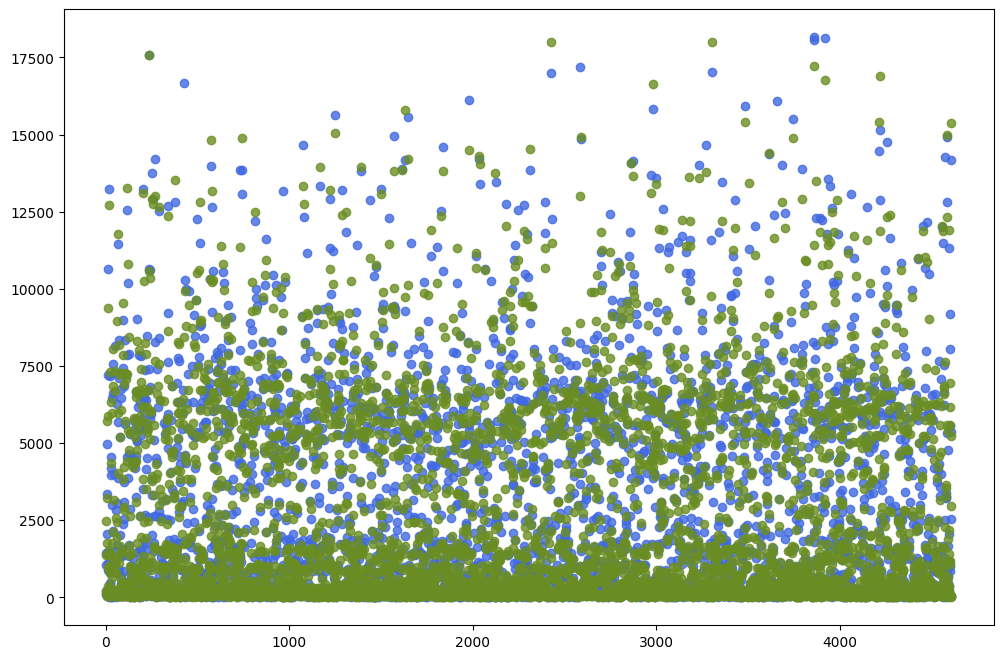

In [17]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
ypred = model.predict(Xtest)


fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(xs, ytest, color ='royalblue', alpha=0.8)

plt.scatter(xs, ypred, color ='olivedrab', alpha=0.8)

plt.show()

144/144 [==============================] - 1s 6ms/step - loss: 290.0336 - mae: 290.0336 - mse: 441315.5000


Text(112.72222222222221, 0.5, 'MAE')

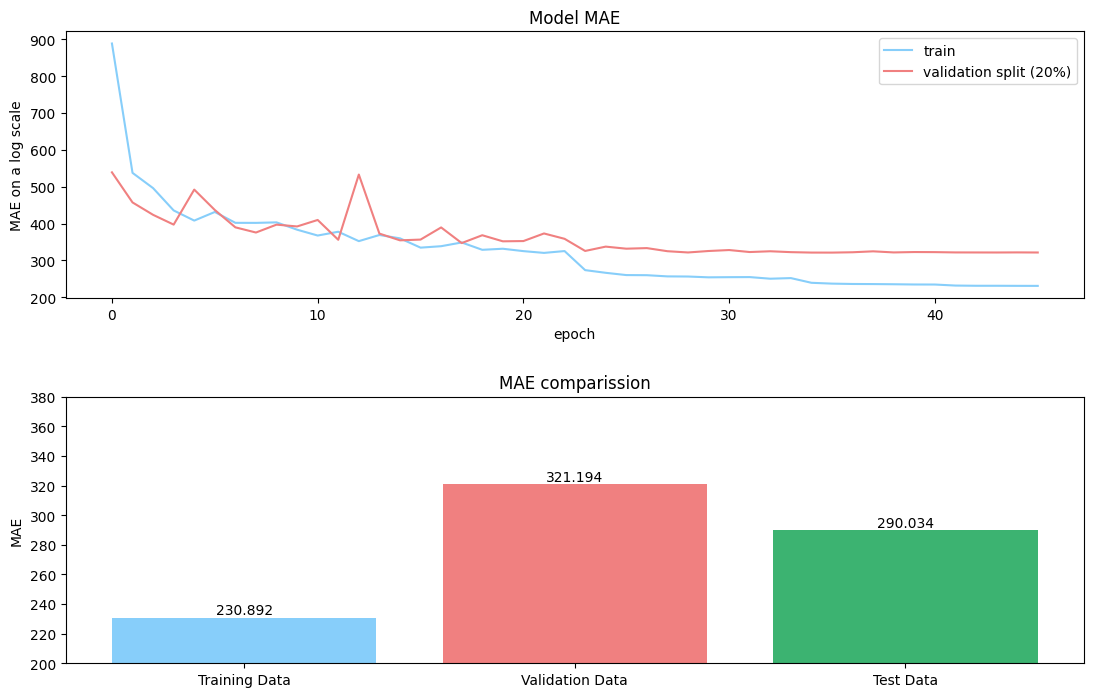

In [18]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
#axs[0].set_yscale("log")

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)

axs[1].bar("Training Data",min(f_mae), color="lightskyblue") #Display minimum mae of the training data set
axs[1].bar("Validation Data", min(f_val_mae), color="lightcoral")#Display minimum mae of the validation data set
axs[1].bar("Test Data", f_test_mae[0], color="mediumseagreen")#Display mae of the test data set
axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')
axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


144/144 [==============================] - 1s 6ms/step - loss: 290.0336 - mae: 290.0336 - mse: 441315.5000


([<matplotlib.axis.XTick at 0x2c30e8550>,
 [Text(0.2, 0, 'Training Data'),
  Text(1.2, 0, 'Validation Data'),
  Text(2.2, 0, 'Test Data')])

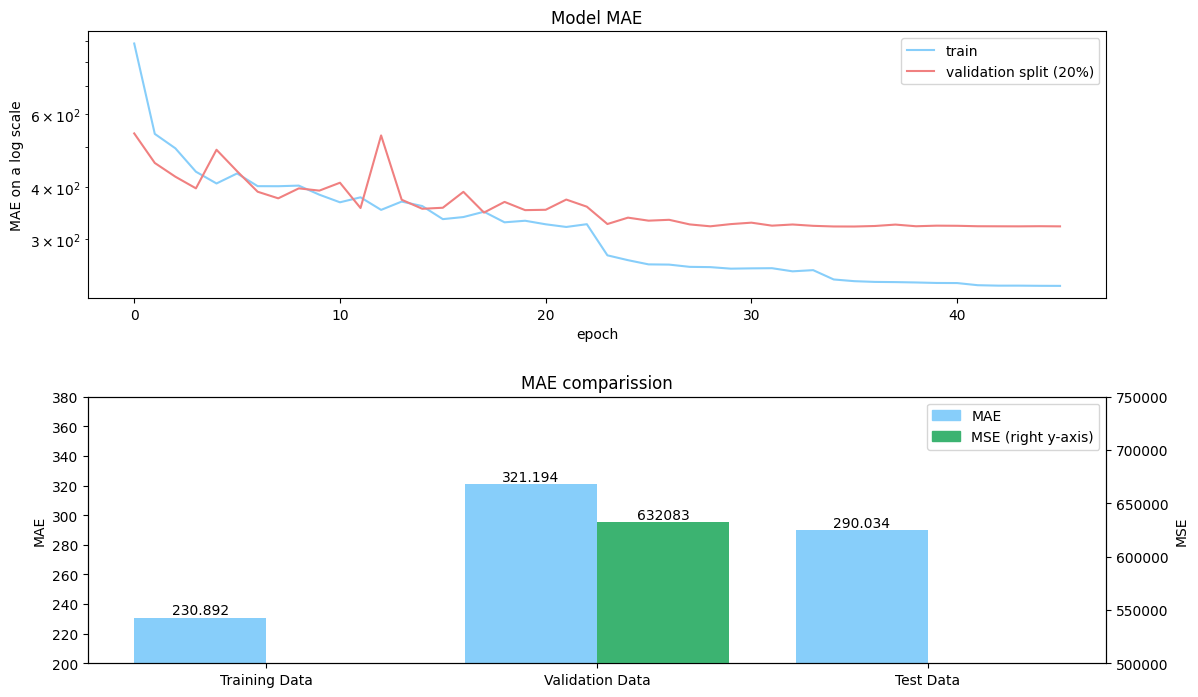

In [19]:
import matplotlib.patches as mpatches

#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
axs[0].set_yscale("log")

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)


axs4 = axs[1].twinx()

x_axis = np.arange(3)

nameofdata = ["Training Data","Validation Data","Test Data"]

f_mse = history.history["mse"]
f_val_mse = history.history["val_mse"]


axs[1].bar(x_axis[0],min(f_mae), color="lightskyblue", width=0.4) #Display minimum mae of the training data set
axs[1].bar(x_axis[1], min(f_val_mae), color="lightskyblue", width=0.4)#Display minimum mae of the validation data set
axs[1].bar(x_axis[2], f_test_mae[0], color="lightskyblue", width=0.4)#Display mae of the test data set

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')

axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


axs4.bar(x_axis[0] +0.4, min(f_mse), color="mediumseagreen", width=0.4)
axs4.bar(x_axis[1]+0.4, min(f_val_mse), color="mediumseagreen", width=0.4,)
axs4.bar(x_axis[2]+0.4, f_test_mae[2], color="mediumseagreen", width=0.4,)
axs4.set_ylabel('MSE')

axs4.bar_label(axs4.containers[0], label_type='edge')
axs4.bar_label(axs4.containers[1], label_type='edge')
axs4.bar_label(axs4.containers[2], label_type='edge')
axs4.set_ylim([500000, 750000])




#Custom Legend
leg_mae = mpatches.Patch(color='lightskyblue', label='MAE')
leg_mse = mpatches.Patch(color='mediumseagreen', label='MSE (right y-axis)')

axs[1].legend(handles=[leg_mae, leg_mse])

plt.xticks(x_axis + 0.2,nameofdata)

### Hyperparamter tuning 

In [20]:
import keras_tuner as kt

In [21]:
# def model_builder(hp): #ADAGRAD BENUTZEN ALS OPTIMZER und LEARNING RATE DECREASE implementieren
 
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten())
    
#     # Tune the number of hidden layers and units in each aswell as the best activation function.
#     # Number of hidden layers: 1 - 8
#     # Number of Units: 32 - 512 with stepsize of 32
#     for i in range(1, hp.Int("num_layers", 2, 7)):
        
#         hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
#         model.add(
#             keras.layers.Dense(
#                 units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
#                 activation=hp_activation)
#             )
        
      
#     # Add output layer.
#     model.add(keras.layers.Dense(units=1, activation="relu"))
    
#     # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.mae,
#                   metrics=["mae"])
    
#     return model


### Test Model

In [39]:
def model_builder(hp): #ADAGRAD BENUTZEN ALS OPTIMZER und LEARNING RATE DECREASE implementieren
 
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    # Tune the number of hidden layers and units in each aswell as the best activation function.
    # Number of hidden layers: 1 - 8
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(hp.Int("num_layers", 6, 12)):
        
       #hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=32),
                activation="relu")
            )
        
      
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [23]:
# def model_builder(hp): #ADAGRAD BENUTZEN ALS OPTIMZER und LEARNING RATE DECREASE implementieren
 
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten())
    
#     # Tune the number of hidden layers and units in each aswell as the best activation function.
#     # Number of hidden layers: 1 - 8
#     # Number of Units: 32 - 512 with stepsize of 32
#     for i in range(1, hp.Int("num_layers", 8, 12)):
        
#        #hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
#         model.add(
#             keras.layers.Dense(
#                 units=128,
#                 activation="relu")
#             )
        
      
#     # Add output layer.
#     model.add(keras.layers.Dense(units=1, activation="relu"))
#     #hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
#     # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
#     #hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
#                   loss=keras.losses.mae,
#                   metrics=["mae"])
    
#     return model

In [40]:
# Create a tuner 
tuner = kt.Hyperband(model_builder,
                     objective='val_mae',
                     max_epochs=100,
                     factor=3,
                     hyperband_iterations=15,
                     overwrite=True,
                     directory='kt_dir',
                     project_name='kt_hyperband')

# Create a stop early function if val_mae doesn't improve over 3 epochs

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00001)
callbacks_list = [stop_early,reduce_lr]

In [42]:
# Execute the tuner  
tuner.search(Xtrain, ytrain, epochs=100, validation_split=0.2, callbacks=callbacks_list)

Trial 24 Complete [00h 00m 19s]
val_mae: 618.9561157226562

Best val_mae So Far: 432.3948974609375
Total elapsed time: 00h 06m 29s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
11                |10                |num_layers
256               |96                |units_0
128               |192               |units_1
192               |64                |units_2
64                |64                |units_3
192               |128               |units_4
192               |192               |units_5
256               |224               |units_6
96                |128               |units_7
192               |64                |units_8
32                |96                |units_9
160               |64                |units_10
256               |32                |units_11
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0    

Traceback (most recent call last):
  File "/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/var/folders/lj/x77cgrfn0ml3pv3407q8vw0c0000gn/T/ipykernel_27906/3409050515.py", line 28, in model_builder
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
  File "/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/training.py", line 736, in compile
    self._configure_steps_per_execution(steps_per_execution or 1)
  File "/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/tensorflow/py

Invalid model 0/5
Epoch 1/2


2022-11-24 21:12:11.861686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1118.8220 - mae: 1118.8220

2022-11-24 21:12:17.724346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 10s 23ms/step - loss: 1118.8220 - mae: 1118.8220 - val_loss: 592.7934 - val_mae: 592.7934 - lr: 0.0100
Epoch 2/2
145/269 [===============>..............] - ETA: 1s - loss: 651.5765 - mae: 651.5765

In [26]:
tuner.results_summary()

Results summary
Results in kt_dir/kt_hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
units_1: 96
units_2: 64
units_3: 64
units_4: 96
units_5: 64
units_6: 64
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 320.4083251953125
Trial summary
Hyperparameters:
num_layers: 5
units_1: 96
units_2: 128
units_3: 96
units_4: 96
units_5: 64
units_6: 96
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 320.84423828125
Trial summary
Hyperparameters:
num_layers: 5
units_1: 96
units_2: 64
units_3: 96
units_4: 64
units_5: 32
units_6: 96
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 321.5268249511719
Trial summary
Hyperparameters:
num_layers: 6
units_1: 128
units_2: 96
units_3: 64
units_4: 128
units_5: 128
units_6: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0051
Score: 321.6112365722656
Trial summary
Hyperparameters:
num_layers: 5
units_

### Further Hypertuning

In [27]:
# Save the best Hyperparameter the tuner has found 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [30]:
# Use the best Hyperparameter to build a new model and train the model on the training Dataset
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=25)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00001)
callbacks_list2 = [stop_early,reduce_lr]

h_model = tuner.hypermodel.build(best_hps)
h_history = h_model.fit(Xtrain, ytrain, epochs=500, validation_split=0.2,
                    callbacks=callbacks_list2)


Epoch 1/350


2022-11-24 20:58:14.572057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 885.5960 - mae: 885.5960

2022-11-24 20:58:17.763183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 4s 12ms/step - loss: 885.5960 - mae: 885.5960 - val_loss: 570.6838 - val_mae: 570.6838 - lr: 0.0100
Epoch 2/350
269/269 [==============================] - 3s 11ms/step - loss: 529.9938 - mae: 529.9938 - val_loss: 479.5738 - val_mae: 479.5738 - lr: 0.0100
Epoch 3/350
269/269 [==============================] - 3s 11ms/step - loss: 475.3491 - mae: 475.3491 - val_loss: 493.3995 - val_mae: 493.3995 - lr: 0.0100
Epoch 4/350
269/269 [==============================] - 3s 10ms/step - loss: 464.1107 - mae: 464.1107 - val_loss: 398.5743 - val_mae: 398.5743 - lr: 0.0100
Epoch 5/350
269/269 [==============================] - 9s 33ms/step - loss: 421.6246 - mae: 421.6246 - val_loss: 380.5959 - val_mae: 380.5959 - lr: 0.0100
Epoch 6/350
269/269 [==============================] - 10s 35ms/step - loss: 402.3330 - mae: 402.3330 - val_loss: 386.8137 - val_mae: 386.8137 - lr: 0.0100
Epoch 7/350
269/269 [==============================] - 8s 28ms/step - loss: 385.3

In [31]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results = evaluate_model(h_model, Xtest, ytest)

# Set index to hypertuned
hyper_results.index = ["Hyperparameter"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results])

results_comparisson.head()



144/144 [==============================] - 1s 5ms/step - loss: 298.7536 - mae: 298.7536


,loss,mae,mse
Startwerte,290.033600,290.033600,441315.5
Hyperparameter,298.753601,298.753601,NaN


### Evaluate and Viusalize the Hypertuned Model 

In [32]:
# Evaluate the model on the test data using `evaluate` result is the corresponding MAE
print("Evaluate on test data")
h_results = h_model.evaluate(Xtest, ytest)
h_results_train = h_model.evaluate(Xtrain, ytrain)
print("HP!! test loss, test mae, test mse:", h_results)
print(" HP!!!! train loss, train mae, train mse:", h_results_train)

Evaluate on test data
336/336 [==============================] - 3s 9ms/step - loss: 265.4058 - mae: 265.4058
HP!! test loss, test mae, test mse: [298.75360107421875, 298.75360107421875]
 HP!!!! train loss, train mae, train mse: [265.4057922363281, 265.4057922363281]


  7/144 [>.............................] - ETA: 1s 

2022-11-24 21:02:00.125310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 4ms/step


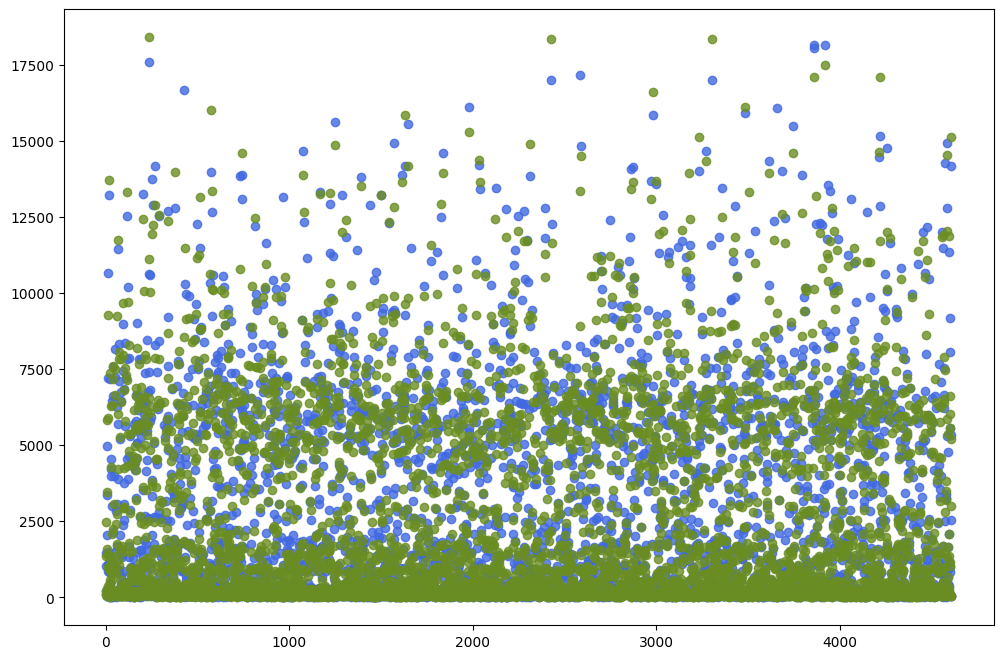

In [33]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
yhpred = h_model.predict(Xtest)


fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(xs, ytest, color ='royalblue', alpha=0.8)

plt.scatter(xs, yhpred, color ='olivedrab', alpha=0.8)

plt.show()

144/144 [==============================] - 1s 6ms/step - loss: 298.7536 - mae: 298.7536


Text(112.72222222222221, 0.5, 'MAE')

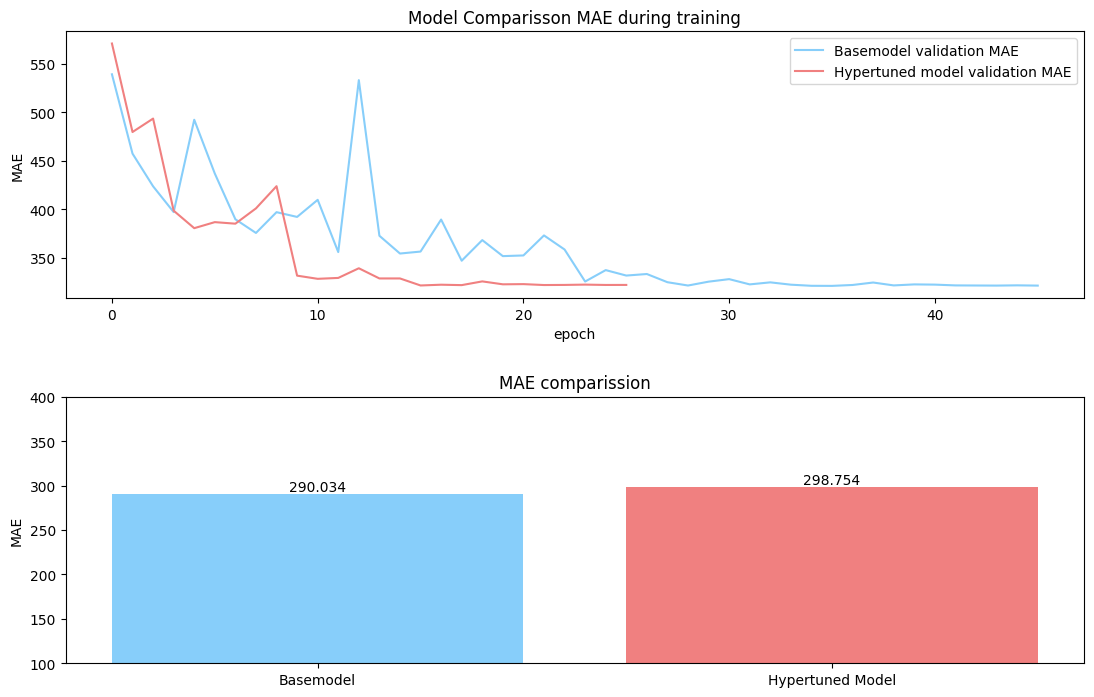

In [38]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['val_mae'], label="Basemodel validation MAE", color="lightskyblue")
axs[0].plot(h_history.history['val_mae'], label="Hypertuned model validation MAE", color="lightcoral")
axs[0].set_title('Model Comparisson MAE during training')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')


base_mae = model.evaluate(Xtest, ytest)
hp_mae = h_model.evaluate(Xtest, ytest)


axs[1].bar("Basemodel", base_mae[0], color="lightskyblue" )
axs[1].bar("Hypertuned Model", hp_mae[0], color="lightcoral")

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].set_ylim([100, 400])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')